In [16]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.python.ops import rnn_cell, rnn
from tensorflow.keras.utils import Sequence
import tensorflow.keras as keras
import tensorflow_probability as tfp
from keras import activations, initializers

import numpy as np
# setting the seed allows for reproducible results
np.random.seed(123)
import pandas as pd


import math

## 1. Basic RNN Model (with constant weights)

Based on the model from the paper "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

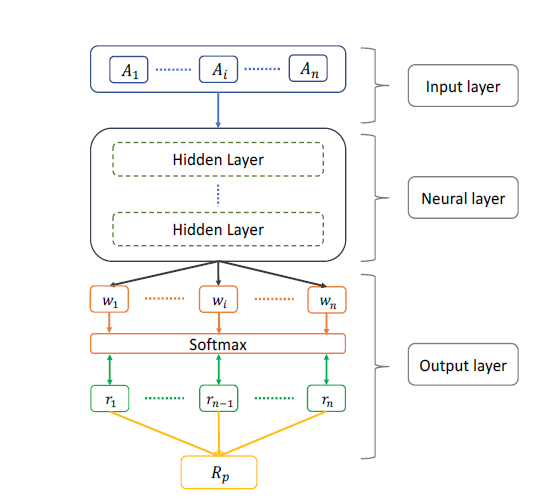

**Figure 1**. Model architecture schematic. Source: "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

The input of the model is the prices and the returns of *n* assets in the portfolio on the window of *k* trading periods (here: days) previous to the moment of prediction. Hence, the input shape for a single prediction is (*n* x *k*).  The output of the model is the vector of portfolio weights derived by applying the *softmax* function to the output of the previous layer which is LSTM layer in our case (but convolution with pooling is also potentially applicable).

The idea behind this model is that within the process of training the estimated Sharpe ratio of a portfolio of assets is directly optimized. In other words, the objective to be maximized is the estimated Sharpe ratio, and it is treated as a function from the trainable parameters of the model (weights of the neural network).

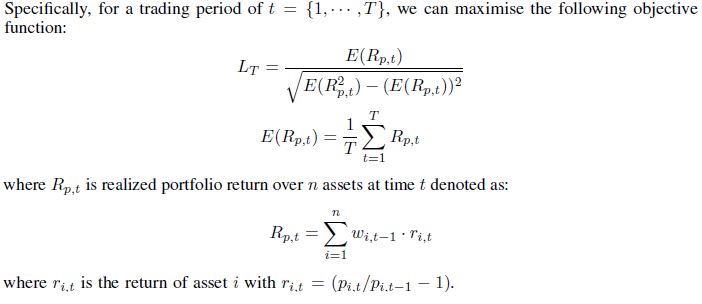

**Figure 2**. Formula for the estimation of a portfolio's Sharpe ratio . Source: "Deep Learning for Portfolio Optimization" (Zhang et al., 2021). 

Above the formula used to estimate the Sharpe ratio in (Zhang et al., 2021). Here lies the difference between the model we implemeted. While the authors of the aforementioned paper suggested estimating the expected value of Sharpe ratio using historical values of asset returns (the ones that are known at the moment of prediction), our approach explores the possibility of exploting future values for more precise estimation of the desired value. Since Sharpe ratio has the role of the function to be optimized during the model training, it serves as a loss function of our neural network. In this framework, future values of asset return we use to calculate the values of this loss function serve as the equivalent of labels in a sense that they represent the information that the model "does not know" at the time of prediction and tries to infer using the trained parameters.

In [17]:
class RNN_model:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units,  
        learning_rate):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets, 
        n_lstm_units - number of LSTM cells in the layer
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            Dense(
                outputs, 
                activation='softmax', 
            )
        ])

        
        # custom loss function - negated Sharpe ratio
        # while y_pred are portfolio weights generated by the model, y are actually values of future asset returns
        def sharpe_loss(y, y_pred):
            
            y_pred = tf.expand_dims(y_pred, axis=2)
            # thus the values of the portfolio returns for the k (50) upcoming periods are estimated
            portfolio_returns = tf.matmul(y, y_pred)
            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)

            # from the future portofio return, we estimated expected value of return and its standard deviation
            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)

            return -sharpe
            
        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, learning_rate,
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets, shape- (lookback window + 1, # of assets)
        
        return: the allocations ratios for each of the given assets
        '''
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

### Note: Data Preprocessing

To fit the data in the model, we need to create some additional variables (asset returns) and lag variables for both asset prices and returns in a quantity corresponding to the size of a lookback (and lookahead) window. We opted for a window of 50 trading days.

In [5]:
# helper function for data preprocessing
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
data = pd.read_csv('starter_data.csv', index_col='Date')
data.head()

,VTI,AGG,DBC,^VIX
Date,,,,
2006-02-06,63.165001,100.209999,24.200001,13.04
2006-02-07,62.549999,100.139999,23.500000,13.59
2006-02-08,63.000000,100.089996,23.400000,12.83
2006-02-09,62.880001,100.150002,23.620001,13.12
2006-02-10,63.009998,99.940002,23.190001,12.87


The assets chosen for the portofio are taken from (Zhang et al., 2021, four market indices: 
* US total stock index (VTI)
* US aggregate bond index (AGG)
* US commodity index (DBC)  
* Volatility Index (VIX).

The data starting from 2006 is in use.

In [6]:
# adding returns and lag variables
data_w_ret = np.concatenate([data.values[1:], data.pct_change().values[1:]], axis=1)
data_reshaped = series_to_supervised(data_w_ret, 49, 1)
data_reshaped.set_index(data[50:].index, inplace=True)

In [13]:
# making the array of future returns (lookahead window is 50 trading days) - used to calculate the loss
all_returns = data.pct_change()[1:].set_index(data[:-1].index)
future_returns = series_to_supervised(all_returns, 0, 50)

### Model configuration and training

In [15]:
# some huperparameters are tuned, some to be adjusted - used for the most of the following models 
model_config = {
    'lb_window':50,
    'la_window':50,
    'validation_split':0,
    'batch_size': 128,
     'n_epochs': 100,
     'n_lstm_units': 16,
     'learning_rate': 0.0016
}

Currenly, we are using the data of the period up to 2011 as the training set, and the data for upcoming 2 years (2011-2012) as the set to evaluate the performance.

In [18]:
base_model = RNN_model()
base_model.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

Epoch 1/100
38/38 [==============================] - 3s 10ms/step - loss: -0.0374
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: -0.0428
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0504
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0587
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0684
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0812
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0978
Epoch 8/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1085
Epoch 9/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1171
Epoch 10/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1217
Epoch 11/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1204
Epoch 12/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1212
Epoch 13/100


38/38 [==============================] - 0s 13ms/step - loss: -0.1707
Epoch 100/100
38/38 [==============================] - 0s 12ms/step - loss: -0.1702


In [19]:
# example for the results
base_model.get_allocations(data_reshaped, timeframe=['2011','2013'])[:50]

array([[0.71386206, 0.16978137, 0.0392394 , 0.07711719],
       [0.7175413 , 0.1667427 , 0.03859179, 0.07712422],
       [0.7157117 , 0.16773   , 0.03963289, 0.07692538],
       [0.71558106, 0.16784334, 0.03964767, 0.0769279 ],
       [0.71863914, 0.16564016, 0.03866351, 0.07705712],
       [0.7171433 , 0.1670647 , 0.03865512, 0.07713684],
       [0.71830463, 0.1658666 , 0.03877785, 0.07705093],
       [0.7210545 , 0.16308606, 0.03900735, 0.07685213],
       [0.72364694, 0.16127849, 0.03809784, 0.07697675],
       [0.7251527 , 0.15959665, 0.03845634, 0.07679433],
       [0.72428447, 0.16002588, 0.03900324, 0.07668639],
       [0.71947396, 0.16473646, 0.03879185, 0.07699775],
       [0.70897454, 0.1732444 , 0.04086636, 0.07691473],
       [0.7012662 , 0.17972621, 0.04210945, 0.07689811],
       [0.7062591 , 0.1749816 , 0.04204252, 0.07671676],
       [0.71202266, 0.17029111, 0.04092097, 0.07676529],
       [0.7146324 , 0.16775784, 0.04097103, 0.07663883],
       [0.7207831 , 0.16256624,

## 2. RNN model with a stochastic layer (weights trained with Bayes by Backprop)

The models that come next have the same architecture as the one above but the stochastic weights applied before the activation of the output layer (*softmax*). This means that not the constant values of the weights are being adjusted in the training process but the parameters of their (normal) distibution. The assumption taken is that the optimal values of the weights in this layer are independently normally distributed.

The algorithm used to train the weights in the case is called Bayes by Backprop, firstly introduced in "Weight Uncertainty in Neural Networks" (Blundell et al., 2015). Important thing to know is the general form of the cost function used for the model training in the algorithm.

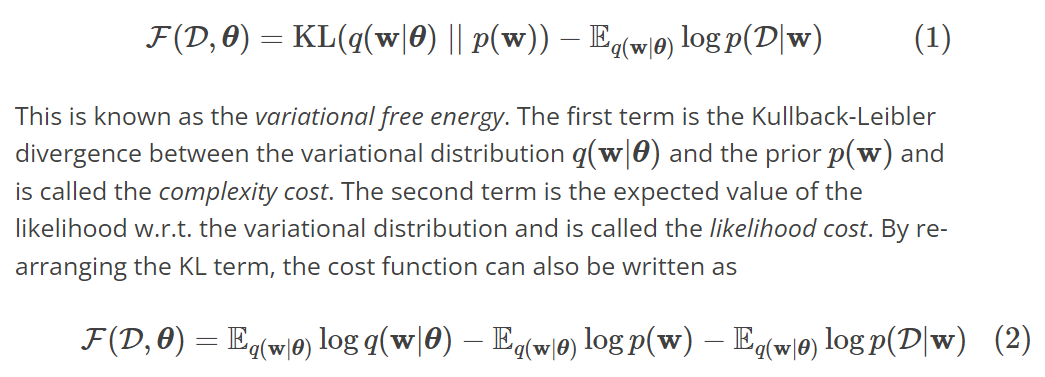

**Figure 3**. Cost function in Bayes by Backprop. Source: Variational inference in Bayesian neural networks (Martin Krasser, http://krasserm.github.io/)

Variation distirution is a distribution of a simplier form (Gaussian) that seeks to best approximate the actual distribution of the model weights in Bayesian framework which is not tractable for the models as complex as neural networks. *Theta* in the formulas above represent the parameters of the weight ditribution (mean and st.dev.) which are the trained parameters. 
The problem we face with out model lies in the third term of (2), expected log-likelihood. In the regular preddiction settings like classification and regression task, log-likelihood is usually represented as cross-entropy and mean squared error, respectively. However, in our case, there are no true values that the model tries to predict, rather it tries to predict the weights that correspond to the predicted maximum value of Sharpe, expected in the future. We took the liberty of replacing the last term in this function with the loss function from our initial model (Sharpe ration estimated based on future asset returns).

### a) Pre-selected prior distribution of weights

Bayesian approach requires to choose the prior distribution of weights which plays a great role in the model training. Following
Blundell et al. (2015), we chose using a scale mixture of two Gaussian densities as the prior. Each density is zero mean, but differing variances. The parameters of the prior distribution are derived through hyperparameter tuning.

In [20]:
# config with the added prameters of the prior
model_config_bbb = {
    'lb_window': 50,
    'la_window': 50,
    'validation_split': 0,
    'batch_size': 128,
    'n_epochs': 100,
    'n_lstm_units': 16,
    'learning_rate': 0.0016,
    'prior_sigma_1': 1.41335,
    'prior_sigma_2': 0.2,
    'prior_pi': 0.1586
}

In [21]:
# Dense layer with stochastic weights
class DenseBayesByBackprop(tf.keras.layers.Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.w_mu = self.add_weight(name='w_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.b_mu = self.add_weight(name='b_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.w_rho = self.add_weight(name='w_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.b_rho = self.add_weight(name='b_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        w_sigma = tf.math.softplus(self.w_rho)
        w = self.w_mu + w_sigma * tf.random.normal(self.w_mu.shape)

        b_sigma = tf.math.softplus(self.b_rho)
        b = self.b_mu + b_sigma * tf.random.normal(self.b_mu.shape)

        # adding complexity cost (see above) to the loss
        self.add_loss(self.kl_loss(w, self.w_mu, w_sigma) +
                      self.kl_loss(b, self.b_mu, b_sigma))

        return self.activation(K.dot(inputs, w) + b)

    def kl_loss(self, weights, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(weights) - self.log_prior_prob(weights))

    def log_prior_prob(self, weights):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(weights) +
                     self.prior_pi_2 * comp_2_dist.prob(weights))

In [22]:
class RNN_model_BayesByBackprop:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        kl_weight, 
        prior_sigma_1, 
        prior_sigma_2, 
        prior_pi, 
        learning_rate):
   
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            DenseBayesByBackprop(
                outputs, 
                kl_weight, 
                activation='softmax', 
                prior_sigma_1=prior_sigma_1,
                prior_sigma_2=prior_sigma_2,
                prior_pi=prior_pi,
            )
        ])

        
        
        def sharpe_loss(y, y_pred):
            
            y_pred = tf.expand_dims(y_pred, axis=2)
            portfolio_returns = tf.matmul(y, y_pred)
            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)


            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)

            return -sharpe

        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0,
              prior_sigma_1=1.5, 
              prior_sigma_2=0.1, 
              prior_pi=0.5,):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        kl_weight = 1/n_batches
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, kl_weight, learning_rate,
                prior_sigma_1, prior_sigma_2, prior_pi
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

In [24]:
model_bbb = RNN_model_BayesByBackprop()
model_bbb.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config_bbb)

Epoch 1/100
38/38 [==============================] - 3s 10ms/step - loss: 5.8452
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 5.7460
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: 5.5426
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 5.3904
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: 5.4427
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 5.2880
Epoch 7/100
38/38 [==============================] - 0s 11ms/step - loss: 5.1819
Epoch 8/100
38/38 [==============================] - 0s 11ms/step - loss: 5.2474
Epoch 9/100
38/38 [==============================] - 0s 11ms/step - loss: 5.0796
Epoch 10/100
38/38 [==============================] - 0s 11ms/step - loss: 5.0546
Epoch 11/100
38/38 [==============================] - 0s 11ms/step - loss: 5.0703
Epoch 12/100
38/38 [==============================] - 0s 11ms/step - loss: 4.8907
Epoch 13/100
38/38 [=====

In [43]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_bbb.get_allocations(data_reshaped, timeframe=['2011','2013'])[:50]

array([[6.6446918e-01, 4.2272024e-02, 6.8853307e-03, 2.8637347e-01],
       [6.7087460e-01, 4.1715249e-02, 6.7980196e-03, 2.8061214e-01],
       [6.5430433e-01, 4.3086655e-02, 7.0031481e-03, 2.9560584e-01],
       [6.6741776e-01, 4.1969370e-02, 6.8320828e-03, 2.8378084e-01],
       [6.6990793e-01, 4.1830592e-02, 6.8048108e-03, 2.8145668e-01],
       [6.7001605e-01, 4.1804042e-02, 6.8093953e-03, 2.8137046e-01],
       [6.5295464e-01, 4.3172855e-02, 7.0230132e-03, 2.9684949e-01],
       [6.3918895e-01, 4.4171143e-02, 7.1792062e-03, 3.0946070e-01],
       [6.4521211e-01, 4.3621711e-02, 7.1065444e-03, 3.0405962e-01],
       [6.2987721e-01, 4.4851579e-02, 7.2851023e-03, 3.1798601e-01],
       [6.3302433e-01, 4.4534173e-02, 7.2413776e-03, 3.1520012e-01],
       [6.5363294e-01, 4.2926729e-02, 7.0051551e-03, 2.9643518e-01],
       [6.6347057e-01, 4.2259093e-02, 6.8832194e-03, 2.8738716e-01],
       [6.6392940e-01, 4.2269185e-02, 6.8836589e-03, 2.8691769e-01],
       [6.5550357e-01, 4.2926878e-

#### Comparison of the performance of the models (fixed and stochastic weights)

In [48]:
# helper function to evaluate the change of the portfolio value allocation the assets following the model predictions
def get_portfolio_values(predicted_weights, returns):
    portfolio_returns = np.sum(predicted_weights * returns, axis=1)
    portfolio_values=[100]
    for p_return in portfolio_returns:
        portfolio_values.append(portfolio_values[-1]*(1+p_return))
    return portfolio_values

100%|██████████| 500/500 [00:43<00:00, 11.37it/s]


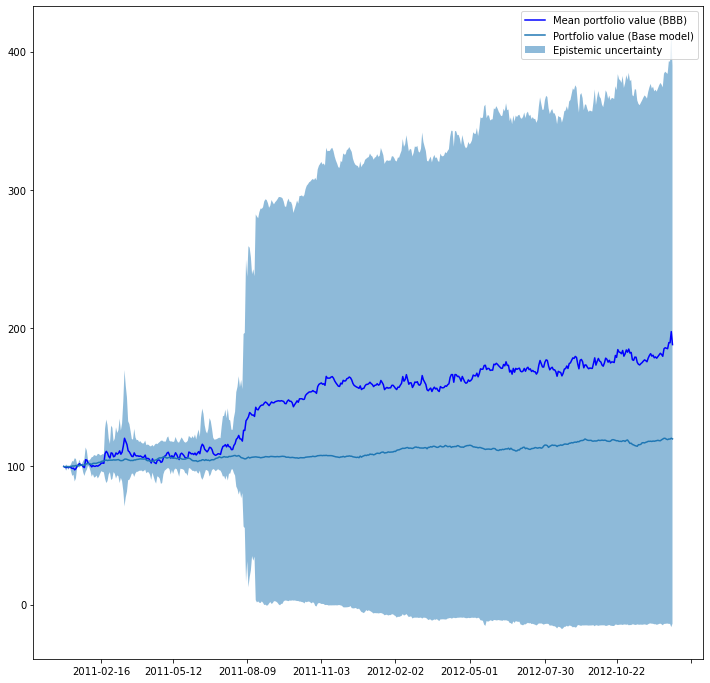

In [50]:
from matplotlib.dates import DateFormatter
import matplotlib

import matplotlib.pyplot as plt
import tqdm

wealth_distribution = []

for i in tqdm.tqdm(range(500)):
    predicted_weights = model_bbb.get_allocations(data_reshaped, timeframe=['2011','2013'])
    sampled_values = get_portfolio_values(predicted_weights, just_returns['2011':'2013'].values)[:-1]
    wealth_distribution.append(sampled_values)
    
wealth_distribution = np.array(wealth_distribution)

wealth_mean_bbb = np.mean(wealth_distribution, axis=0)
wealth_sigma_bbb = np.std(wealth_distribution, axis=0)
sampled_wo_bayes = get_portfolio_values(
    base_model.get_allocations(data_reshaped, timeframe=['2011','2013']), 
    just_returns['2011':'2013'].values)[:-1]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(all_returns['2011':'2013'].index, wealth_mean_bbb, 'b-', label='Mean portfolio value (BBB)')
ax.plot(all_returns['2011':'2013'].index, sampled_wo_bayes, label='Portfolio value (Base model)')
ax.fill_between(just_returns['2011':'2013'].index, 
                 wealth_mean_bbb + 2 * wealth_sigma_bbb, 
                 wealth_mean_bbb - 2 * wealth_sigma_bbb, 
                 alpha=0.5, label='Epistemic uncertainty')

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
plt.legend()

In [51]:
sampled_wo_bayes[-1], wealth_mean_bbb[-1]

(119.92946973887257, 188.1291854250293)

<AxesSubplot:xlabel='Date'>

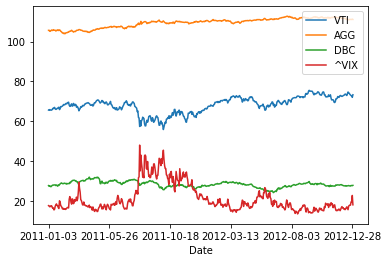

In [52]:
data['2011':'2013'].plot()

###  b) Trainable prior

Library *TensorFlow Probability* contains the inplemetation of the Dense layer with stochastic weights. For training, it exploits the same cost function as the previous algorithm (reformulated ELBO). Nonetheless, it also allows the prior to be trained along with posterior.

In [53]:
tfd = tfp.distributions


# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [55]:
class RNN_model_variational:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        kl_weight, 
        learning_rate):
        
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            tfp.layers.DenseVariational(
                outputs, 
                posterior_mean_field, 
                prior_trainable,
                kl_weight, 
                activation='softmax', 
            )
        ])

        
        
        def sharpe_loss(y, y_pred):
            
            y_pred = tf.expand_dims(y_pred, axis=2)
            portfolio_returns = tf.matmul(y, y_pred)
            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)


            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            return -sharpe
            
        opt = keras.optimizers.Adam(learning_rate)
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0
             ):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        kl_weight = 1/n_batches
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, kl_weight, learning_rate
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
       
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

In [57]:
model_variational = RNN_model_variational()
model_variational.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

Epoch 1/100
38/38 [==============================] - 3s 11ms/step - loss: -0.0078
Epoch 2/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0615
Epoch 3/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0339
Epoch 4/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0375
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0286
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0523
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0577
Epoch 8/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0394
Epoch 9/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0630
Epoch 10/100
38/38 [==============================] - 0s 11ms/step - loss: -0.0386
Epoch 11/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0531
Epoch 12/100
38/38 [==============================] - 0s 12ms/step - loss: -0.0268
Epoch 13/100


38/38 [==============================] - 1s 14ms/step - loss: -0.0588
Epoch 100/100
38/38 [==============================] - 1s 14ms/step - loss: -0.0438


In [63]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_variational.get_allocations(data_reshaped, timeframe=['2011','2013'])[:50]

array([[0.03084271, 0.90255   , 0.0473271 , 0.01928022],
       [0.03085675, 0.9025279 , 0.04733011, 0.01928526],
       [0.03084369, 0.90255123, 0.04732492, 0.01928016],
       [0.03085733, 0.9025286 , 0.04732877, 0.01928527],
       [0.03086358, 0.90251803, 0.04733079, 0.0192876 ],
       [0.03085266, 0.902534  , 0.04732943, 0.01928384],
       [0.03084   , 0.902556  , 0.04732511, 0.01927895],
       [0.03083142, 0.9025716 , 0.04732151, 0.01927545],
       [0.03083533, 0.90256387, 0.04732379, 0.01927712],
       [0.03082783, 0.9025784 , 0.04731989, 0.01927381],
       [0.0308282 , 0.9025781 , 0.04731978, 0.01927399],
       [0.03083282, 0.90256727, 0.04732358, 0.01927639],
       [0.03083987, 0.9025552 , 0.04732573, 0.01927915],
       [0.03083134, 0.902567  , 0.04732528, 0.01927632],
       [0.03083747, 0.9025589 , 0.04732533, 0.01927828],
       [0.03085182, 0.9025354 , 0.04732922, 0.0192836 ],
       [0.03082901, 0.9025754 , 0.04732092, 0.01927466],
       [0.03083641, 0.9025636 ,

100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


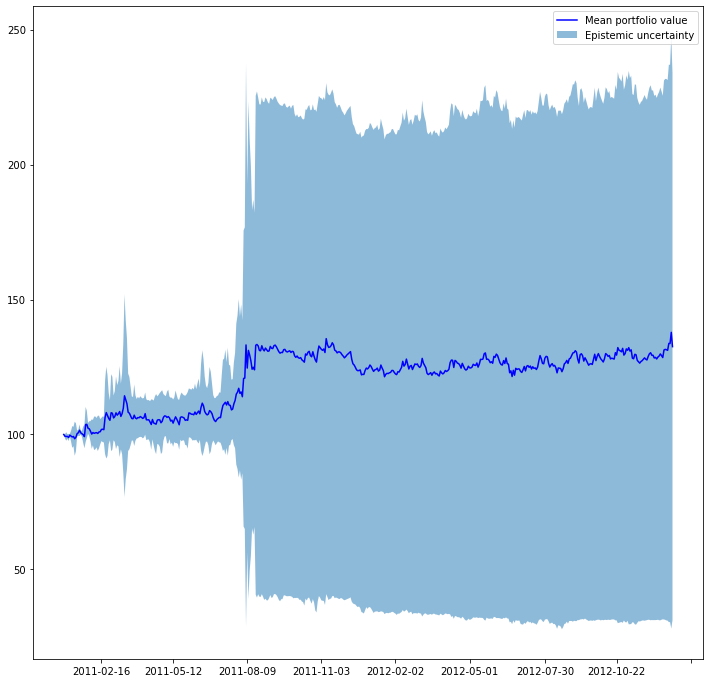

In [64]:
wealth_distribution = []

for i in tqdm.tqdm(range(500)):
    predicted_weights = model_variational.get_allocations(data_reshaped, timeframe=['2011','2013'])
    sampled_values = get_portfolio_values(predicted_weights, just_returns['2011':'2013'].values)[:-1]
    wealth_distribution.append(sampled_values)
    
wealth_distribution = np.array(wealth_distribution)

wealth_mean_variational = np.mean(wealth_distribution, axis=0)
wealth_sigma_variational = np.std(wealth_distribution, axis=0)

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(just_returns['2011':'2013'].index, wealth_mean_variational, 'b-', label='Mean portfolio value');
ax.fill_between(just_returns['2011':'2013'].index, 
                 wealth_mean_variational + 2 * wealth_sigma_variational, 
                 wealth_mean_variational - 2 * wealth_sigma_variational, 
                 alpha=0.5, label='Epistemic uncertainty')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
plt.legend()

In [65]:
wealth_mean_variational[-1]

132.543109434058

### 3. Stochastic RNN model with Flipout

*TensorFlow Probability* also offers the implementation of the Dense layer with Flipout estimator. Flipout is presented in the paper of Wen et al. (2018). This method decorrelates the gradients within a mini-batch during the model training by implicitly sampling pseudo-independent weight perturbations for each example. As the result, the ideal linear variance reduction for fully connected networks, convolutional networks, and RNNs is achieved.

In [66]:
class RNN_model_flipout:
    
    def __init__(self):
        self.model = None
        
        
    def __build_model(
        self, 
        input_shape, 
        outputs, 
        n_lstm_units, 
        learning_rate):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(n_lstm_units, input_shape=input_shape),
            Flatten(),
            tfp.layers.DenseFlipout(
                outputs,  
                activation='softmax', 
            )
        ])

        
        
        def sharpe_loss_flipout(y, y_pred):
            
            y_pred = tf.expand_dims(y_pred, axis=2)
            portfolio_returns = tf.matmul(y, y_pred)
            portfolio_returns = tf.squeeze(portfolio_returns, axis=2)


            sharpe = K.mean(portfolio_returns, axis=1) / K.std(portfolio_returns, axis=1)

            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)

            return -sharpe + sum(self.model.losses)/self.n_samples
            
        
        model.compile(loss=sharpe_loss_flipout, optimizer='adam')
        return model
    
    def train(self, 
              input_train: pd.DataFrame, 
              future_returns: pd.DataFrame, 
              timeframe: list, 
              batch_size, 
              n_epochs, 
              n_lstm_units,
              learning_rate,
              lb_window=50, 
              la_window=50,
              validation_split=0
             ):
        
        self.lb_window = lb_window
        self.la_window = la_window
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_lstm_units = n_lstm_units
        
        
        # data with returns
       
        fit_data = input_train[timeframe[0]:timeframe[1]]
        fut_ret = future_returns[timeframe[0]:timeframe[1]]
        
        self.n_samples = len(fit_data)
        
        fit_data = fit_data.values.reshape(fit_data.shape[0], lb_window, int(len(input_train.columns)/lb_window))
        fut_ret = fut_ret.values.reshape(fut_ret.shape[0], la_window, int(len(fut_ret.columns)/la_window))
        
        n_batches = np.ceil(fit_data.shape[0]/batch_size)
        
        fit_data = tf.cast(tf.constant(fit_data), dtype='float32')
        fut_ret = tf.cast(tf.constant(fut_ret), dtype='float32')
        
        
        
        if self.model is None:
            self.model = self.__build_model(
                (lb_window, fit_data.shape[2]), int(fit_data.shape[2]/2), 
                n_lstm_units, learning_rate
            )
        

        self.model.fit(fit_data, fut_ret, epochs=n_epochs, 
                       shuffle=False, validation_split=validation_split,)
        
        
    def get_allocations(self, input_pred: pd.DataFrame, timeframe: list):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets, shape- (lookback window + 1, # of assets)
        
        return: the allocations ratios for each of the given assets
        '''
        pred_data = input_pred[timeframe[0]:timeframe[1]]
        pred_data = pred_data.values.reshape(pred_data.shape[0], self.lb_window, int(len(input_pred.columns)/self.lb_window))
        
        return self.model.predict(pred_data)

In [67]:
model_flipout = RNN_model_flipout()
model_flipout.train(data_reshaped, future_returns, timeframe=['2006-04-19','2011'], **model_config)

Epoch 1/100


C:\Users\Makar\anaconda3\envs\master_thesis\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\Makar\anaconda3\envs\master_thesis\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


38/38 [==============================] - 3s 12ms/step - loss: 161.5190
Epoch 2/100
38/38 [==============================] - 0s 13ms/step - loss: 159.0444
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: 156.6241
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 154.2344
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 151.8627
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 149.5055
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 147.1563
Epoch 8/100
38/38 [==============================] - 0s 11ms/step - loss: 144.8125
Epoch 9/100
38/38 [==============================] - 0s 12ms/step - loss: 142.4739
Epoch 10/100
38/38 [==============================] - 0s 12ms/step - loss: 140.1420
Epoch 11/100
38/38 [==============================] - 0s 11ms/step - loss: 137.8154
Epoch 12/100
38/38 [==============================] - 0s 11ms/step - loss: 135.4932
Epoch 13/100


38/38 [==============================] - 0s 12ms/step - loss: 3.2516
Epoch 100/100
38/38 [==============================] - 0s 12ms/step - loss: 2.9473


In [74]:
# if the cell is run multiple times, each time the allocation suggested by the model is different since the weights are stochastic
model_flipout.get_allocations(data_reshaped, timeframe=['2011','2013'])[:50]

array([[0.76565576, 0.0643776 , 0.1391768 , 0.03078988],
       [0.7938273 , 0.08962591, 0.09138709, 0.0251598 ],
       [0.6883935 , 0.17354748, 0.03037452, 0.10768455],
       [0.7451154 , 0.16431774, 0.04253556, 0.04803135],
       [0.5243977 , 0.0938355 , 0.09575445, 0.28601232],
       [0.7936508 , 0.08965749, 0.09152067, 0.02517104],
       [0.3120835 , 0.17499854, 0.37878653, 0.1341314 ],
       [0.8602497 , 0.09434205, 0.02325406, 0.02215418],
       [0.89402574, 0.02739163, 0.06225907, 0.01632356],
       [0.8008012 , 0.04503533, 0.14401829, 0.01014518],
       [0.30449992, 0.4482122 , 0.11615583, 0.131132  ],
       [0.4138829 , 0.286245  , 0.15730014, 0.14257199],
       [0.45234227, 0.2538495 , 0.1724845 , 0.12132371],
       [0.42153156, 0.23650457, 0.16055718, 0.1814066 ],
       [0.4216038 , 0.23648949, 0.16067757, 0.18122913],
       [0.26372322, 0.29713017, 0.26208314, 0.17706351],
       [0.46504596, 0.32141167, 0.05356664, 0.1599757 ],
       [0.31495994, 0.15474053,

100%|██████████| 500/500 [00:46<00:00, 10.66it/s]


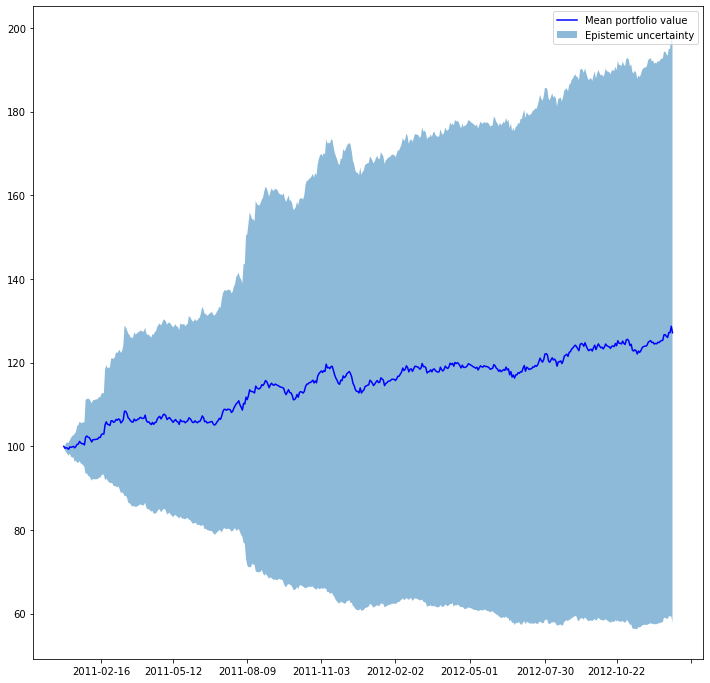

In [75]:
wealth_distribution = []

for i in tqdm.tqdm(range(500)):
    predicted_weights = model_flipout.get_allocations(data_reshaped, timeframe=['2011','2013'])
    sampled_values = get_portfolio_values(predicted_weights, just_returns['2011':'2013'].values)[:-1]
    wealth_distribution.append(sampled_values)
    
wealth_distribution = np.array(wealth_distribution)

wealth_mean_flipout = np.mean(wealth_distribution, axis=0)
wealth_sigma_flipout = np.std(wealth_distribution, axis=0)

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(just_returns['2011':'2013'].index, wealth_mean_flipout, 'b-', label='Mean portfolio value');
ax.fill_between(just_returns['2011':'2013'].index, 
                 wealth_mean_flipout + 2 * wealth_sigma_flipout, 
                 wealth_mean_flipout - 2 * wealth_sigma_flipout, 
                 alpha=0.5, label='Epistemic uncertainty')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
plt.legend()

In [76]:
wealth_mean_flipout[-1]

127.13631331512119

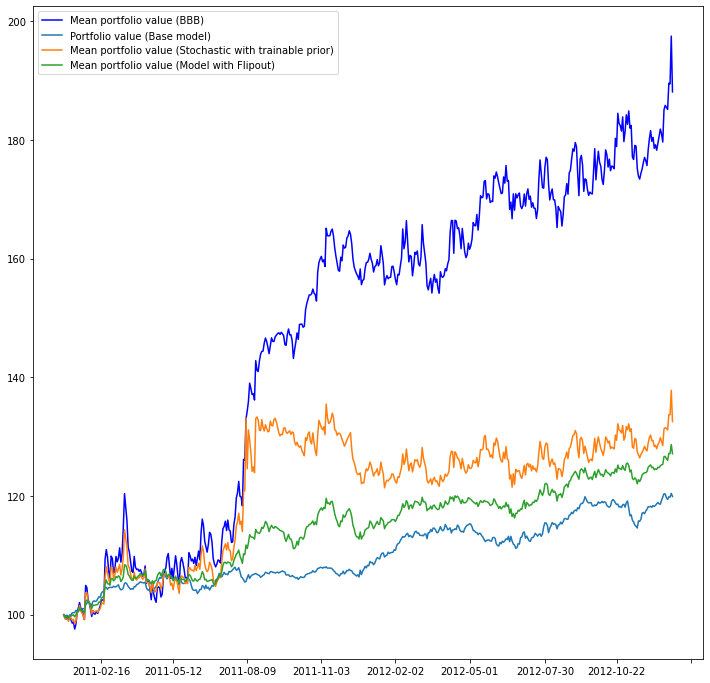

In [78]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(all_returns['2011':'2013'].index, wealth_mean_bbb, 'b-', label='Mean portfolio value (BBB)')
ax.plot(all_returns['2011':'2013'].index, sampled_wo_bayes, label='Portfolio value (Base model)')
ax.plot(all_returns['2011':'2013'].index, wealth_mean_variational, label='Mean portfolio value (Stochastic with trainable prior)')
ax.plot(all_returns['2011':'2013'].index, wealth_mean_flipout, label='Mean portfolio value (Model with Flipout)')

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
plt.legend()

## Next steps

* Exploring uncertainty of models in the predicted allocations (not resulting portfolio returns) and looking for a way to exploit its values in the investment strategy
* Adjusting for volatility and transaction costs
* Stochastic weights not only in the final Dense layer but in LSTM cells as well
* 1D CNNs with and without stochastic weights
* MC-Dropout? (Dropout as a Bayesian Approximation:Representing Model Uncertainty in Deep Learning - Gal and Ghahramani, 2016)